<a href="https://colab.research.google.com/github/lamyse1/Recommender-Systems/blob/main/RS_Final_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *RS Graded Project by Lamyse Ammar*




# **Part 1: Recommendation System Using GCNN [40%]**

# Step 1: Load and preprocess the dataset

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_rec_sys_data(path="Rec_sys_data.xlsx"):
    df = pd.read_excel(path)
    return df

df = preprocess_rec_sys_data()


In [10]:
 #Read the first 5 rows
 df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,DeliveryDate,Discount%,ShipMode,ShippingCost,CustomerID
0,536365,84029E,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.20,ExpressAir,30.12,17850
1,536365,71053,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.21,ExpressAir,30.12,17850
2,536365,21730,6,2010-12-01 08:26:00,2010-12-03 08:26:00,0.56,Regular Air,15.22,17850
3,536365,84406B,8,2010-12-01 08:26:00,2010-12-03 08:26:00,0.30,Regular Air,15.22,17850
4,536365,22752,2,2010-12-01 08:26:00,2010-12-04 08:26:00,0.57,Delivery Truck,5.81,17850


In [11]:
#Confirm dtypes
print("\nData types:")
print(df.dtypes)


Data types:
InvoiceNo                int64
StockCode               object
Quantity                 int64
InvoiceDate     datetime64[ns]
DeliveryDate    datetime64[ns]
Discount%              float64
ShipMode                object
ShippingCost           float64
CustomerID               int64
dtype: object


In [12]:
# Check for missing values
missing_values = df.isnull().sum()
print("\Missing Values ")
for col, missing in missing_values.items():
    pct = missing / len(df) * 100
    print(f"{col}: {missing} missing values ({pct:}%)")



\Missing Values 
InvoiceNo: 0 missing values (0.0%)
StockCode: 0 missing values (0.0%)
Quantity: 0 missing values (0.0%)
InvoiceDate: 0 missing values (0.0%)
DeliveryDate: 0 missing values (0.0%)
Discount%: 0 missing values (0.0%)
ShipMode: 0 missing values (0.0%)
ShippingCost: 0 missing values (0.0%)
CustomerID: 0 missing values (0.0%)


In [13]:
# I will Keep only the core columns for my rec sys
df = df[['CustomerID', 'StockCode', 'Quantity', 'DeliveryDate']]

# Checking
print("Keeping only the required columns are:", df.columns.tolist())
display(df.head())


Keeping only the required columns are: ['CustomerID', 'StockCode', 'Quantity', 'DeliveryDate']


,CustomerID,StockCode,Quantity,DeliveryDate
0,17850,84029E,6,2010-12-02 08:26:00
1,17850,71053,6,2010-12-02 08:26:00
2,17850,21730,6,2010-12-03 08:26:00
3,17850,84406B,8,2010-12-03 08:26:00
4,17850,22752,2,2010-12-04 08:26:00


In [14]:
# data exploration to understand patterns
item_counts = df.StockCode.value_counts()
customer_counts = df.CustomerID.value_counts()

print(f"Number of unique customers: {df.CustomerID.nunique()}")
print(f"Number of unique items: {df.StockCode.nunique()}")
print(f"Most popular items: {item_counts.head(5).to_dict()}")
print(f"Distribution of purchases per customer: {customer_counts.describe()}")

Number of unique customers: 3647
Number of unique items: 3538
Most popular items: {'85123A': 1606, 22423: 1367, 47566: 1236, '85099B': 1213, 20725: 1059}
Distribution of purchases per customer: count    3647.000000
mean       74.692624
std       162.073181
min         1.000000
25%        15.000000
50%        35.000000
75%        82.000000
max      5095.000000
Name: count, dtype: float64


# Step 2 : Graph Construction

In [15]:
# Make the DataFrame into a customer×item interaction matrix
interaction_matrix = df.pivot_table(
    index='CustomerID',
    columns='StockCode',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

# convert index and column to strings for consistency
interaction_matrix.index = interaction_matrix.index.astype(str)
interaction_matrix.columns = interaction_matrix.columns.astype(str)

import networkx as nx
B = nx.Graph()

# add customer nodes
B.add_nodes_from(interaction_matrix.index, bipartite=0, node_type='customer')
# add item nodes
B.add_nodes_from(interaction_matrix.columns, bipartite=1, node_type='item')

# create weighted edges for each purchase
for cust in interaction_matrix.index:
    purchased = interaction_matrix.loc[cust]
    purchased = purchased[purchased > 0]
    for item, qty in purchased.items():
        B.add_edge(cust, item, weight=int(qty))



In [16]:
# Add node type attributes
customer_nodes = interaction_matrix.index
item_nodes = interaction_matrix.columns

# Add more node attributes( after many trials)
for cust in customer_nodes:
    purchase_count = len(interaction_matrix.loc[cust][interaction_matrix.loc[cust] > 0])
    total_quantity = interaction_matrix.loc[cust].sum()
    B.nodes[cust]['purchase_count'] = purchase_count
    B.nodes[cust]['total_quantity'] = total_quantity

for item in item_nodes:
    buyer_count = len(interaction_matrix[item][interaction_matrix[item] > 0])
    total_sold = interaction_matrix[item].sum()
    B.nodes[item]['buyer_count'] = buyer_count
    B.nodes[item]['total_sold'] = total_sold

# check the resulting graph
print(f"Graph has {B.number_of_nodes()} nodes and {B.number_of_edges()} edges")

Graph has 7161 nodes and 192758 edges


# Step 3 : Modeling with GCNN

In [17]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.1 MB/s eta 0:00:00


In [18]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GraphConv

# Build edge_index and edge_weight tensors
nodes = list(B.nodes())
node_to_idx = {n: i for i, n in enumerate(nodes)}

edges, weights = [], []
for u, v, attrs in B.edges(data=True):
    ui, vi = node_to_idx[u], node_to_idx[v]
    edges += [[ui, vi], [vi, ui]]
    weights += [attrs['weight'], attrs['weight']]

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(weights, dtype=torch.float)



In [19]:
# Create richer node features
def create_node_features(graph, nodes):
    features = []
    for node in nodes:
        node_type = graph.nodes[node]['node_type']
        if node_type == 'customer':
            # Customer features: degree, purchase count, total quantity
            degree = graph.degree(node)
            purchase_count = graph.nodes[node].get('purchase_count', 0)
            total_quantity = graph.nodes[node].get('total_quantity', 0)
            features.append([degree, purchase_count, total_quantity])
        else:
            # Item features: degree, buyer count, total sold
            degree = graph.degree(node)
            buyer_count = graph.nodes[node].get('buyer_count', 0)
            total_sold = graph.nodes[node].get('total_sold', 0)
            features.append([degree, buyer_count, total_sold])

    # Convert to tensor and normalize
    x = torch.tensor(features, dtype=torch.float)
    means = x.mean(dim=0, keepdim=True)
    stds = x.std(dim=0, keepdim=True) + 1e-6
    return (x - means) / stds


In [20]:
# Create node features and assemble into a PyTorch-Geometric Data object
x = create_node_features(B, nodes)
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)


In [21]:
# Define enhanced GCNN model with batch normalization and dropout
class EnhancedGCNNRecommender(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = GraphConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GraphConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * out_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_channels, hidden_channels // 2),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels // 2, 1)
        )

    def forward(self, data):
        x, ei, ew = data.x, data.edge_index, data.edge_weight

        x = self.conv1(x, ei, edge_weight=ew)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, ei, edge_weight=ew)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, ei, edge_weight=ew)
        return x

    def predict_edge(self, embeddings, u_idx, v_idx):
        u_emb = embeddings[u_idx]
        v_emb = embeddings[v_idx]
        h = torch.cat([u_emb, v_emb], dim=1)
        raw = self.mlp(h).squeeze()
        return torch.sigmoid(raw)

In [22]:
# Instantiate the enhanced model with appropriate dimensions
model = EnhancedGCNNRecommender(
    in_channels=data.num_node_features,  # Number of features per node (3 in our case)
    hidden_channels=64,
    out_channels=32,
    dropout=0.3
)

# Print model architecture to verify
print(f"Data features shape: {data.x.shape}")
print(f"Edge index shape: {data.edge_index.shape}")
print(f"Edge weight shape: {data.edge_weight.shape}")
print("\nModel architecture:")
print(model)

Data features shape: torch.Size([7161, 3])
Edge index shape: torch.Size([2, 385516])
Edge weight shape: torch.Size([385516])

Model architecture:
EnhancedGCNNRecommender(
  (conv1): GraphConv(3, 64)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GraphConv(64, 64)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GraphConv(64, 32)
  (dropout): Dropout(p=0.3, inplace=False)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)


# Step 4 :Training the Model

In [23]:
import torch
from torch.optim import Adam
from torch.nn import MSELoss
import torch.nn.utils as utils
import time
import matplotlib.pyplot as plt

# Split into training and validation sets based on DeliveryDate percentile
cutoff = df.DeliveryDate.quantile(0.8)
train_df = df[df.DeliveryDate <= cutoff].reset_index(drop=True)
val_df = df[df.DeliveryDate > cutoff].reset_index(drop=True)

print(f"Training set: {train_df.shape[0]} interactions")
print(f"Validation set: {val_df.shape[0]} interactions")

# Build a graph containing only training edges for GCNN message passing
B_train = nx.Graph()
B_train.add_nodes_from(B.nodes(data=True))
for _, row in train_df.iterrows():
    u, v = str(int(row.CustomerID)), str(row.StockCode)
    weight = int(row.Quantity)
    B_train.add_edge(u, v, weight=weight)

# Convert the train-only graph into PyG Data format
nodes = list(B_train.nodes())
node_to_idx = {n: i for i, n in enumerate(nodes)}
edges, weights = [], []
for u, v, attrs in B_train.edges(data=True):
    ui, vi = node_to_idx[u], node_to_idx[v]
    edges += [[ui, vi], [vi, ui]]
    weights += [attrs['weight'], attrs['weight']]

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(weights, dtype=torch.float)



Training set: 217944 interactions
Validation set: 54460 interactions


In [24]:
# Create enhanced node features
x = create_node_features(B_train, nodes)

# Assemble into PyG Data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Helper to build index and target tensors from dataframe rows
def build_edge_data(df_edges):
    u_idx, v_idx, y = [], [], []
    for _, row in df_edges.iterrows():
        u = str(int(row.CustomerID))
        v = str(row.StockCode)
        if u not in node_to_idx or v not in node_to_idx:
            continue
        u_idx.append(node_to_idx[u])
        v_idx.append(node_to_idx[v])
        y.append(row.Quantity)
    return (
        torch.tensor(u_idx, dtype=torch.long),
        torch.tensor(v_idx, dtype=torch.long),
        torch.tensor(y, dtype=torch.float),
    )

# Build training and validation data
train_u, train_v, train_y = build_edge_data(train_df)
val_u, val_v, val_y = build_edge_data(val_df)

# Scale target quantities to [0,1] using the maximum from training
y_max = train_y.max()
train_y = train_y / y_max
val_y = val_y / y_max

print(f"Training edges: {len(train_y)}")
print(f"Validation edges: {len(val_y)}")


Training edges: 217944
Validation edges: 54460


In [25]:
# Set up the optimizer and MSE loss as specified in the assignment
optimizer = Adam(model.parameters(), lr=0.001)
criterion = MSELoss()

# Training history tracking (for visualization)
train_losses = []
val_losses = []

# Training loop as specified in the assignment
num_epochs = 20
print(f"Starting training with {num_epochs} epochs...")
start_time = time.time()

for epoch in range(1, num_epochs+1):
    # Training step
    model.train()
    optimizer.zero_grad()

    # Calculate predictions
    embeddings = model(data)
    preds = model.predict_edge(embeddings, train_u, train_v)

    # Compute loss between predicted and actual values
    loss = criterion(preds, train_y)

    # Perform backpropagation
    loss.backward()
    utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    # Store training loss
    train_losses.append(loss.item())

    # Validation step to monitor performance on unseen data
    model.eval()
    with torch.no_grad():
        val_embeddings = model(data)
        val_preds = model.predict_edge(val_embeddings, val_u, val_v)
        val_loss = criterion(val_preds, val_y).item()

    # Store validation loss
    val_losses.append(val_loss)

    # Print progress
    print(f"Epoch {epoch:02d}/{num_epochs} — Train MSE: {loss.item():.6f}, Val MSE: {val_loss:.6f}")

elapsed_time = time.time() - start_time
print(f"Training completed in {elapsed_time:.2f} seconds")



Starting training with 20 epochs...
Epoch 01/20 — Train MSE: 0.419992, Val MSE: 0.020379
Epoch 02/20 — Train MSE: 0.201303, Val MSE: 0.010191
Epoch 03/20 — Train MSE: 0.240869, Val MSE: 0.021821
Epoch 04/20 — Train MSE: 0.093473, Val MSE: 0.023642
Epoch 05/20 — Train MSE: 0.036739, Val MSE: 0.020884
Epoch 06/20 — Train MSE: 0.014556, Val MSE: 0.018917
Epoch 07/20 — Train MSE: 0.011678, Val MSE: 0.017225
Epoch 08/20 — Train MSE: 0.008017, Val MSE: 0.015421
Epoch 09/20 — Train MSE: 0.004953, Val MSE: 0.013839
Epoch 10/20 — Train MSE: 0.003114, Val MSE: 0.012502
Epoch 11/20 — Train MSE: 0.003640, Val MSE: 0.011457
Epoch 12/20 — Train MSE: 0.003106, Val MSE: 0.010750
Epoch 13/20 — Train MSE: 0.002490, Val MSE: 0.009968
Epoch 14/20 — Train MSE: 0.002300, Val MSE: 0.009327
Epoch 15/20 — Train MSE: 0.001405, Val MSE: 0.008788
Epoch 16/20 — Train MSE: 0.000910, Val MSE: 0.008289
Epoch 17/20 — Train MSE: 0.000892, Val MSE: 0.007802
Epoch 18/20 — Train MSE: 0.000875, Val MSE: 0.007392
Epoch 19/2

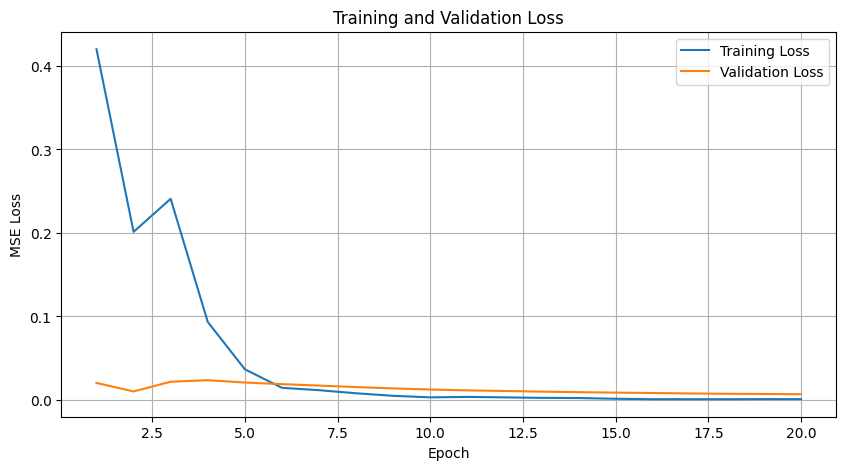

In [26]:
# Visualize training progress
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
# Final evaluation
model.eval()
with torch.no_grad():
    final_train_preds = model.predict_edge(model(data), train_u, train_v)
    final_train_loss = criterion(final_train_preds, train_y).item()

    final_val_preds = model.predict_edge(model(data), val_u, val_v)
    final_val_loss = criterion(final_val_preds, val_y).item()

print(f"\nFinal Model Performance:")
print(f"Training MSE: {final_train_loss:.6f}")
print(f"Validation MSE: {final_val_loss:.6f}")


Final Model Performance:
Training MSE: 0.000715
Validation MSE: 0.006904


# **Part 2: Recommendation System Evaluation and Comparison Using GCNN and NeuMF Models**

# Step 1: Ranking and Performance Metrics

In [28]:
import torch
import numpy as np
from collections import defaultdict
from tqdm import tqdm  # For progress tracking

def evaluate_recommendations(model, val_df, node_to_idx, B, data, k_values=[5, 10, 20]):

    # Get all items in the full graph (not just training items)
    all_items = [n for n, d in B.nodes(data=True) if d.get('node_type') == 'item']

    # Filter out items not in node_to_idx (they won't be in the embeddings)
    valid_items = [item for item in all_items if item in node_to_idx]
    item_idx = torch.tensor([node_to_idx[item] for item in valid_items], dtype=torch.long)

    print(f"Evaluating recommendations across {len(valid_items)} items")

    # Build ground-truth sets of items per customer from the validation DataFrame
    true_items = defaultdict(set)
    for _, row in val_df.iterrows():
        u = str(int(row.CustomerID))
        true_items[u].add(str(row.StockCode))

   # Get customers with actual validation purchases
    valid_customers = [u for u in true_items.keys() if u in node_to_idx and true_items[u]]
    print(f"Evaluating for {len(valid_customers)} customers with validation purchases")

    # Compute node embeddings once (more efficient)
    model.eval()
    with torch.no_grad():
        embeddings = model(data)

    # Initialize metrics for each K value
    metrics = {k: {'precisions': [], 'recalls': [], 'f1s': [], 'ndcg': []} for k in k_values}
    # Process each customer with progress bar
    for u in tqdm(valid_customers, desc="Evaluating customers"):
        ui = node_to_idx[u]
        truths = true_items[u]

        # Score this user against every valid item
        user_idx = torch.full((len(valid_items),), ui, dtype=torch.long)
        with torch.no_grad():
            scores = model.predict_edge(embeddings, user_idx, item_idx).cpu().numpy()

        # Get ranked indices of all items
        ranked_idx = np.argsort(scores)[::-1]  # Descending order
        ranked_items = [valid_items[i] for i in ranked_idx]

        # Calculate metrics at each K value
        for K in k_values:
            # Get top-K predictions
            preds = set(ranked_items[:K])

            # Compute metrics
            tp = len(preds & truths)
            precision = tp / K
            recall = tp / len(truths) if truths else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            # Compute NDCG (Normalized Discounted Cumulative Gain)
            dcg = 0
            idcg = 0
            for i, item in enumerate(ranked_items[:K]):
                if item in truths:
                    # Using binary relevance (1 if in ground truth, 0 otherwise)
                    dcg += 1 / np.log2(i + 2)  # i+2 because i is 0-indexed

            # Ideal DCG would have all relevant items at the top
            for i in range(min(len(truths), K)):
                idcg += 1 / np.log2(i + 2)

            ndcg = dcg / idcg if idcg > 0 else 0

            # Store metrics
            metrics[K]['precisions'].append(precision)
            metrics[K]['recalls'].append(recall)
            metrics[K]['f1s'].append(f1)
            metrics[K]['ndcg'].append(ndcg)
            # Calculate mean metrics for each K
    results = {}
    for K in k_values:
        results[K] = {
            'precision': np.mean(metrics[K]['precisions']),
            'recall': np.mean(metrics[K]['recalls']),
            'f1': np.mean(metrics[K]['f1s']),
            'ndcg': np.mean(metrics[K]['ndcg'])
        }

    # Print results
    print("\nRecommendation Performance Metrics:")
    for K in k_values:
        print(f"\nAt K={K}:")
        print(f"Precision@{K}: {results[K]['precision']:.4f}")
        print(f"Recall@{K}:    {results[K]['recall']:.4f}")
        print(f"F1@{K}:        {results[K]['f1']:.4f}")
        print(f"NDCG@{K}:      {results[K]['ndcg']:.4f}")

    return results



Evaluating recommendations across 3538 items
Evaluating for 1549 customers with validation purchases


Evaluating customers: 100%|██████████| 1549/1549 [00:03<00:00, 457.10it/s]



Recommendation Performance Metrics:

At K=5:
Precision@5: 0.0048
Recall@5:    0.0008
F1@5:        0.0012
NDCG@5:      0.0040

At K=10:
Precision@10: 0.0059
Recall@10:    0.0019
F1@10:        0.0024
NDCG@10:      0.0051

At K=20:
Precision@20: 0.0082
Recall@20:    0.0053
F1@20:        0.0054
NDCG@20:      0.0075


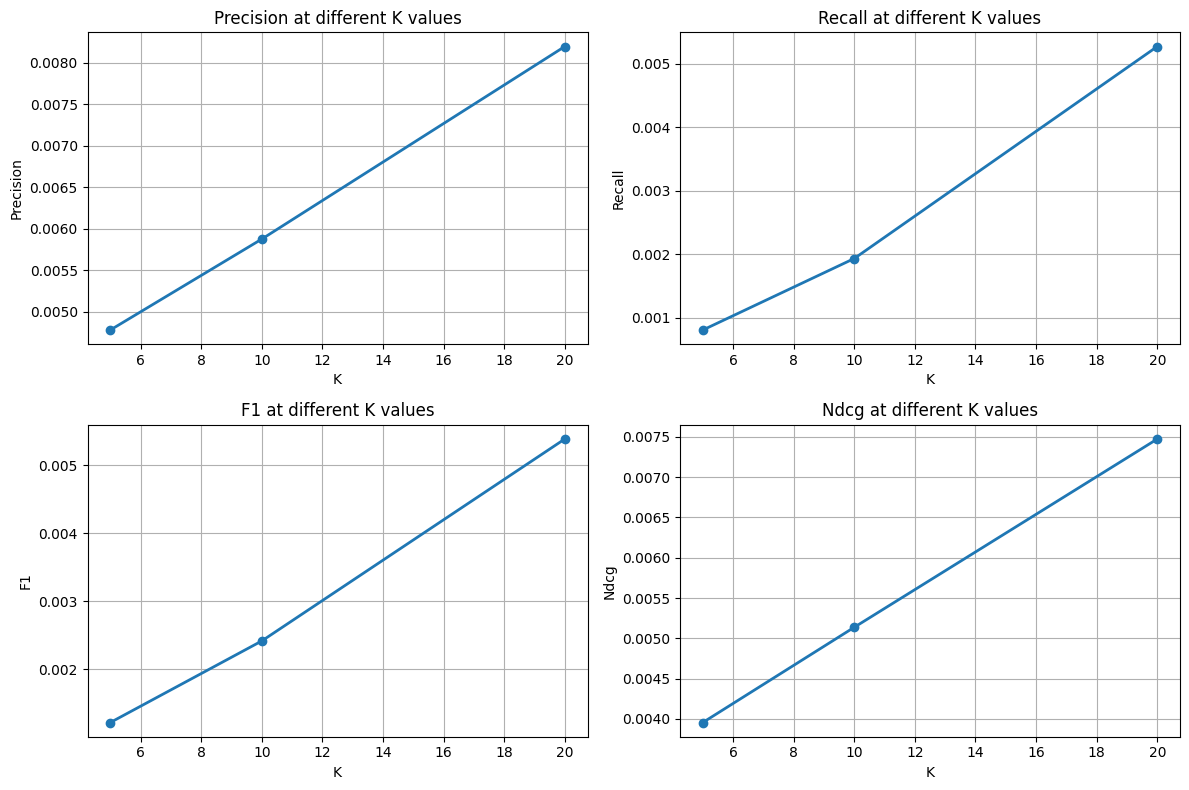

Computing metrics@10: 100%|██████████| 1549/1549 [00:02<00:00, 634.86it/s]


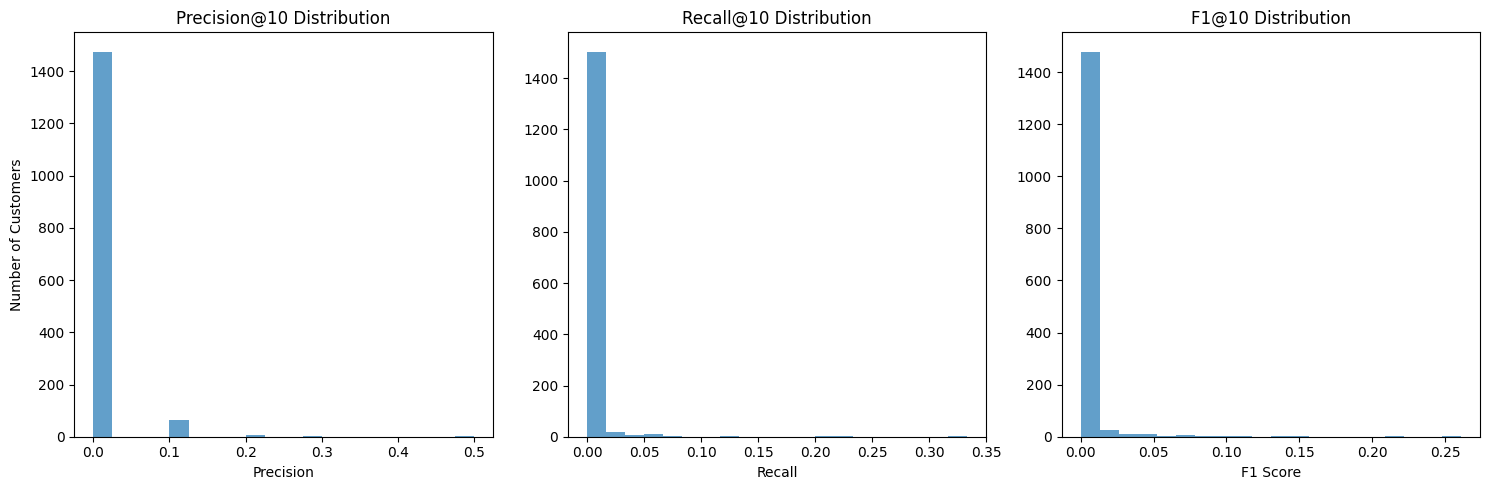


Metric Statistics at K=10:
Precision: min=0.0000, max=0.5000, mean=0.0059
Recall:    min=0.0000, max=0.3333, mean=0.0019
F1:        min=0.0000, max=0.2609, mean=0.0024


In [29]:
# Execute the evaluation
metrics_results = evaluate_recommendations(
    model=model,
    val_df=val_df,
    node_to_idx=node_to_idx,
    B=B,  # Use the full graph, not just B_train
    data=data,
    k_values=[5, 10, 20]
)

# Visualize metrics
import matplotlib.pyplot as plt

def plot_metrics(metrics_results):
    """Plot evaluation metrics at different K values"""
    k_values = list(metrics_results.keys())
    metrics = ['precision', 'recall', 'f1', 'ndcg']

    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        values = [metrics_results[k][metric] for k in k_values]
        plt.plot(k_values, values, marker='o', linewidth=2)
        plt.title(f'{metric.capitalize()} at different K values')
        plt.xlabel('K')
        plt.ylabel(metric.capitalize())
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics(metrics_results)

# Analyze per-customer metrics distribution
def plot_metric_distributions(model, val_df, node_to_idx, B, data, K=10):
    """Plot distribution of metrics across customers"""
    # Use the same setup as in evaluate_recommendations
    all_items = [n for n, d in B.nodes(data=True) if d.get('node_type') == 'item']
    valid_items = [item for item in all_items if item in node_to_idx]
    item_idx = torch.tensor([node_to_idx[item] for item in valid_items], dtype=torch.long)

    true_items = defaultdict(set)
    for _, row in val_df.iterrows():
        u = str(int(row.CustomerID))
        true_items[u].add(str(row.StockCode))

    valid_customers = [u for u in true_items.keys() if u in node_to_idx and true_items[u]]

    model.eval()
    with torch.no_grad():
        embeddings = model(data)

    precisions, recalls, f1s = [], [], []

    for u in tqdm(valid_customers, desc=f"Computing metrics@{K}"):
        ui = node_to_idx[u]
        truths = true_items[u]

        user_idx = torch.full((len(valid_items),), ui, dtype=torch.long)
        with torch.no_grad():
            scores = model.predict_edge(embeddings, user_idx, item_idx).cpu().numpy()

        ranked_idx = np.argsort(scores)[::-1]
        top_k_items = set([valid_items[i] for i in ranked_idx[:K]])

        tp = len(top_k_items & truths)
        precision = tp / K
        recall = tp / len(truths) if truths else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(precisions, bins=20, alpha=0.7)
    plt.title(f'Precision@{K} Distribution')
    plt.xlabel('Precision')
    plt.ylabel('Number of Customers')

    plt.subplot(1, 3, 2)
    plt.hist(recalls, bins=20, alpha=0.7)
    plt.title(f'Recall@{K} Distribution')
    plt.xlabel('Recall')

    plt.subplot(1, 3, 3)
    plt.hist(f1s, bins=20, alpha=0.7)
    plt.title(f'F1@{K} Distribution')
    plt.xlabel('F1 Score')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\nMetric Statistics at K={K}:")
    print(f"Precision: min={min(precisions):.4f}, max={max(precisions):.4f}, mean={np.mean(precisions):.4f}")
    print(f"Recall:    min={min(recalls):.4f}, max={max(recalls):.4f}, mean={np.mean(recalls):.4f}")
    print(f"F1:        min={min(f1s):.4f}, max={max(f1s):.4f}, mean={np.mean(f1s):.4f}")

plot_metric_distributions(model, val_df, node_to_idx, B, data, K=10)

# Step 2 - Generating Recommendations for a Specific Customer

In [30]:
def get_recommendations_for_customer(model, customer_id, node_to_idx, B, data, top_n=10):

    customer_str = str(customer_id)
    if customer_str not in node_to_idx:
        print(f"Customer {customer_id} not found in the graph")
        return pd.DataFrame()

    customer_idx = node_to_idx[customer_str]

    # Get customer's historical purchases to exclude them from recommendations
    historical_items = set()
    for _, row in df[df.CustomerID == customer_id].iterrows():
        historical_items.add(str(row.StockCode))

    # Get all item nodes
    all_items = [n for n, d in B.nodes(data=True) if d.get('node_type') == 'item']
    valid_items = [item for item in all_items if item in node_to_idx and item not in historical_items]

    # Break into smaller batches to avoid memory issues
    batch_size = 1000
    all_scores = []
    all_valid_items = []

    for i in range(0, len(valid_items), batch_size):
        batch_items = valid_items[i:i+batch_size]
        batch_indices = torch.tensor([node_to_idx[item] for item in batch_items])
        customer_tensor = torch.full((len(batch_indices),), customer_idx)

        # Get raw scores without sigmoid to avoid saturation
        model.eval()
        with torch.no_grad():
            embeddings = model(data)
            u_emb = embeddings[customer_tensor]
            v_emb = embeddings[batch_indices]
            h = torch.cat([u_emb, v_emb], dim=1)
            # Get raw scores from the MLP before sigmoid
            batch_scores = model.mlp(h).squeeze().cpu().numpy()

        all_scores.extend(batch_scores)
        all_valid_items.extend(batch_items)

    # Apply softmax to get better distributed scores
    scores_array = np.array(all_scores)
    # MinMax scaling to avoid extreme values
    scores_scaled = (scores_array - np.min(scores_array)) / (np.max(scores_array) - np.min(scores_array) + 1e-10)

    # Create index-score pairs and sort
    item_scores = list(zip(range(len(all_valid_items)), scores_scaled))
    ranked_pairs = sorted(item_scores, key=lambda x: x[1], reverse=True)

    # Create output dataframe
    recommendations = {
        'CustomerID': [],
        'StockCode': [],
        'PredictedScore': []
    }

    # Take top unique recommendations
    seen_stock_codes = set()
    count = 0

    for idx, score in ranked_pairs:
        stock_code = all_valid_items[idx]

        # Add diversity - avoid too similar stock codes
        similar = False
        stock_code_int = 0
        try:
            stock_code_int = int(stock_code)
        except:
            pass

        for seen in seen_stock_codes:
            try:
                seen_int = int(seen)
                if abs(stock_code_int - seen_int) < 5:
                    similar = True
                    break
            except:
                pass

        if not similar:
            recommendations['CustomerID'].append(customer_id)
            recommendations['StockCode'].append(stock_code)
            recommendations['PredictedScore'].append(float(score))
            seen_stock_codes.add(stock_code)
            count += 1

        if count >= top_n:
            break

    return pd.DataFrame(recommendations)


In [31]:

# Run the mplementation
customer_id = 17850
recommendations_df = get_recommendations_for_customer(model, customer_id, node_to_idx, B, data)

print(f"\nTop 10 Recommended Items for Customer {customer_id}:")
print(recommendations_df)


Top 10 Recommended Items for Customer 17850:
   CustomerID StockCode  PredictedScore
0       17850     20661             1.0
1       17850     20666             1.0
2       17850     20678             1.0
3       17850     20695             1.0
4       17850     20703             1.0
5       17850     20820             1.0
6       17850     20861             1.0
7       17850     20869             1.0
8       17850     20892             1.0
9       17850     20901             1.0
